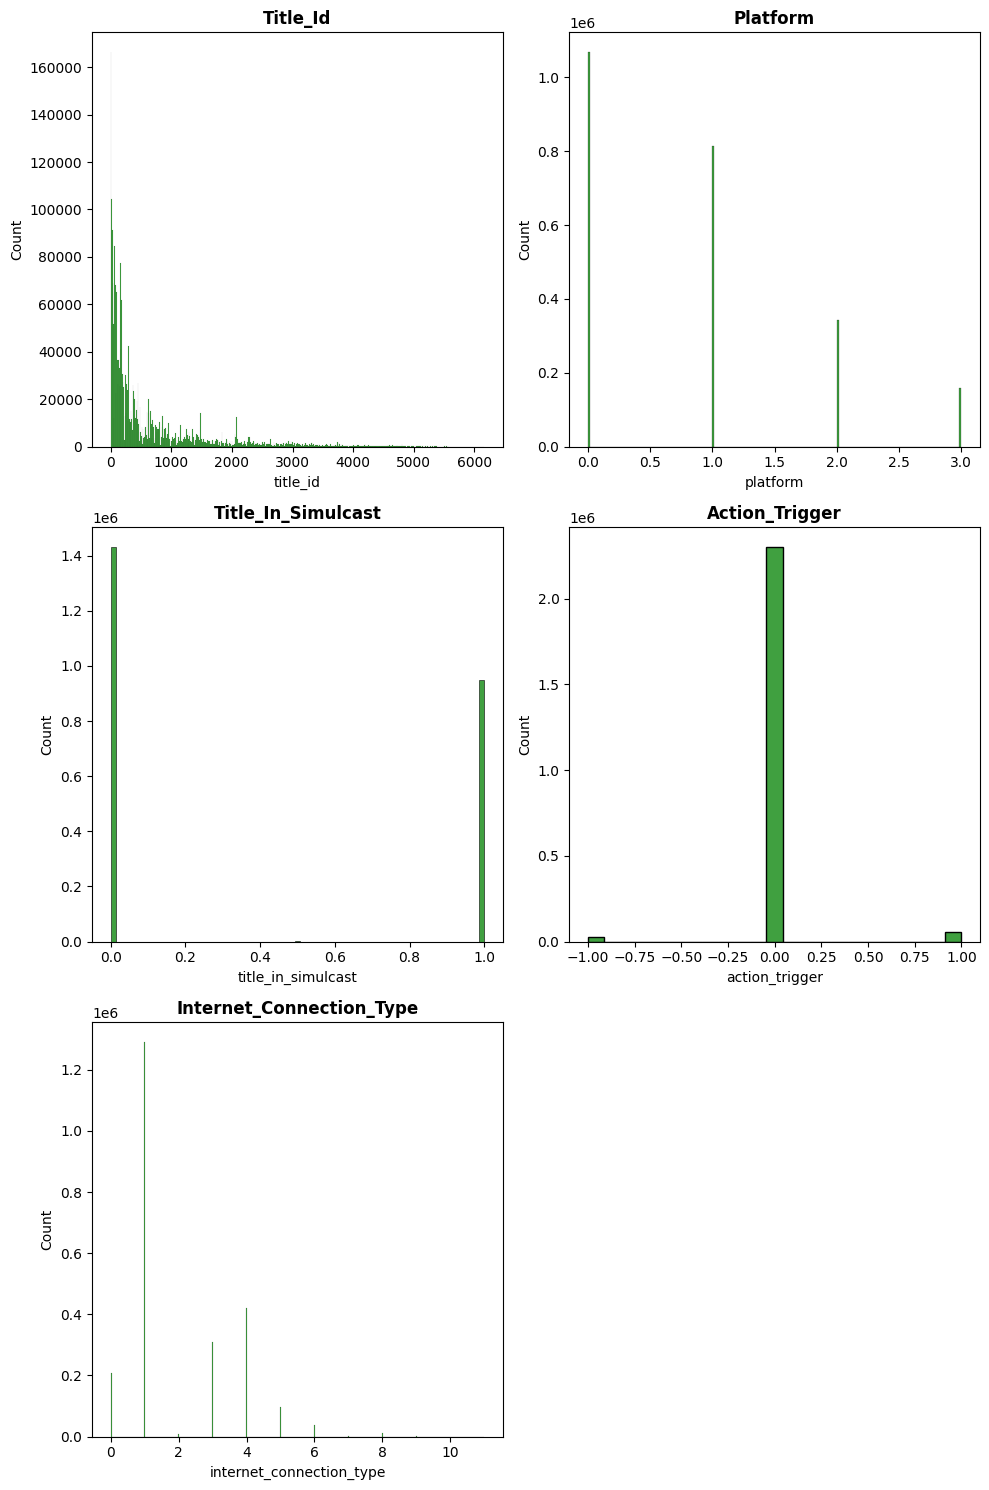

In [ ]:
target = ['title_id', 'platform', 'title_in_simulcast', 'action_trigger', 'internet_connection_type']
plt.figure(figsize=(10,15))
for n,column in enumerate(target):
    plot=plt.subplot(3,2,n+1)
    sns.histplot(df[column],color='green')
    plt.title(f'{column.title()}',weight='bold')
    plt.tight_layout()

#### 套件環境

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab/資料分析期末') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['data',
 'models',
 'preprocessed_output',
 '過往東東',
 'share_data',
 'model選特徵0601.ipynb',
 'LSTM_GRU_torch_ensemble.ipynb',
 'train的其餘特徵.ipynb',
 'XGBoost.ipynb',
 'submit.csv',
 'LSTM_CV.ipynb',
 'LSTM_torch_duration.ipynb',
 'test其餘特徵處理.ipynb']

In [ ]:
# always needed
import math, os, random, csv
import pandas as pd
import numpy as np

# log and save
import json, logging, pickle, sys, shutil, copy
# torch
import torch
import torch.nn
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, ReLU
import torchvision
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import seaborn as sns

# others
import matplotlib.pyplot as plt
from PIL import Image

# sklearn
from sklearn import preprocessing

# statistics
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statistics

# seeds
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# 正文
## 前處理
- user_id:
De-identification user id. The training set has user_id 0 to 30459, while the testing set has user_id 30460 to 38075.
- device_id:
De-identification device id.
- session_id:
The set of consecutive events. It is unique for an individual user, but a session_id may map to multiple user_id.
- platform:
The OS in which the event occurred. Four types in total.
- internet_connection_type :
12 types in total.
- event_time:
The timestamp of the event is logged.
- title_id:
When the event is logged, the encoded title of the movie/drama the user is watching.
- action_trigger:
The action triggers the event, 14 in total.
- played_duration:
When the event is triggered, the length of the movie/drama has been played (in seconds).
- title_in_simulcast:
If the drama is aired weekly, "1" is logged; otherwise, you see "0". "2" means unknown.

In [ ]:
df = pd.read_csv("./data/new_test_source.csv")
df['title_in_simulcast'] = df['title_in_simulcast'].map({ 1:1, 2:0.5, 0:0})
df['action_trigger'] = df['action_trigger'].map({ 0:0, 1:0, 2:0, 3:0, 4:-1, 5:1, 6:1, 7:-1, 8:1, 9:0, 10:0, 11:1, 12:1, 13:1})
df['internet_connection_type'] = df['internet_connection_type'].map({ 0:1, 1:1, 2:1, 3:1, 4:-1, 5:-1, 6:-1, 7:-1, 8:0, 9:0, 10:0, 11:0})

df['event_time'] = pd.to_datetime(df['event_time'], unit='s')
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-09-17')

num_days = (end_date - start_date).days
amount_ppl = len(df['user_id'].unique())
df

,user_id,device_id,session_id,title_id,event_time,played_duration,action_trigger,platform,title_in_simulcast,internet_connection_type,trans_title
0,30460,139780,4203642,134,2022-02-14 14:06:14.704999936,919,0,0,1.0,1,6066
1,30460,139780,4203766,134,2022-02-14 15:54:15.818000128,1,0,0,1.0,1,6066
2,30460,139780,4206734,331,2022-02-16 11:05:10.180999936,22,0,0,1.0,1,5822
3,30460,139780,4217713,331,2022-02-24 12:13:47.158999808,1220,0,0,1.0,1,5822
4,30460,139780,4193024,398,2022-03-07 09:22:50.085999872,9,0,0,1.0,1,5995
...,...,...,...,...,...,...,...,...,...,...,...
2382746,38075,174948,5252063,625,2022-09-11 17:56:20.437999872,4886,0,1,0.0,1,6017
2382747,38075,174948,5252063,625,2022-09-11 17:56:25.912000000,5,0,1,0.0,1,6017
2382748,38075,174948,5252063,625,2022-09-11 17:56:31.231000064,1,0,1,0.0,1,6017
2382749,38075,174948,5252064,625,2022-09-15 15:38:47.340000000,4823,0,1,0.0,1,6017


In [ ]:
# #scaling
# from sklearn.preprocessing import StandardScaler
# columns_to_standardize = ['action_trigger', 'title_in_simulcast', 'internet_connection_type', 'trans_title']
# scaler = StandardScaler()
# df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

In [ ]:
df

,user_id,device_id,session_id,title_id,event_time,played_duration,action_trigger,platform,title_in_simulcast,internet_connection_type,trans_title
0,30460,139780,4203642,134,2022-02-14 14:06:14.704999936,919,-0.070907,0,1.227430,0.556328,0.531040
1,30460,139780,4203766,134,2022-02-14 15:54:15.818000128,1,-0.070907,0,1.227430,0.556328,0.531040
2,30460,139780,4206734,331,2022-02-16 11:05:10.180999936,22,-0.070907,0,1.227430,0.556328,0.141519
3,30460,139780,4217713,331,2022-02-24 12:13:47.158999808,1220,-0.070907,0,1.227430,0.556328,0.141519
4,30460,139780,4193024,398,2022-03-07 09:22:50.085999872,9,-0.070907,0,1.227430,0.556328,0.417696
...,...,...,...,...,...,...,...,...,...,...,...
2382746,38075,174948,5252063,625,2022-09-11 17:56:20.437999872,4886,-0.070907,1,-0.815173,0.556328,0.452817
2382747,38075,174948,5252063,625,2022-09-11 17:56:25.912000000,5,-0.070907,1,-0.815173,0.556328,0.452817
2382748,38075,174948,5252063,625,2022-09-11 17:56:31.231000064,1,-0.070907,1,-0.815173,0.556328,0.452817
2382749,38075,174948,5252064,625,2022-09-15 15:38:47.340000000,4823,-0.070907,1,-0.815173,0.556328,0.452817


In [ ]:
time_slots = []
for i in range(num_days):
    # 01:00-隔天01:00
    start_slot = start_date + pd.DateOffset(hours=i*24) + pd.DateOffset(hours=1)
    end_slot = start_date + pd.DateOffset(hours=(i+1)*24) + pd.DateOffset(hours=1)
    time_slots.append((start_slot, end_slot))

In [ ]:
def plat_trans(platform) -> int:
    if platform == 0:
        return [1,0,0,0]
    elif platform == 1:
        return [0,1,0,0]
    elif platform == 2:
        return [0,0,1,0]
    elif platform == 3:
        return [0,0,0,1]

## 開始處理特徵
  這次保留user_id方便用group_by &方便觀察<br>
  但底下使用iloc需要去調整，畢竟Index從0開始

In [ ]:
user_ids = np.arange(30460, 30460+amount_ppl)
all_user_ids = pd.DataFrame({'user_id': user_ids}) #確保每個人都有在這次的df, 沒出現=0

df_simulcast = pd.DataFrame(np.zeros((amount_ppl, num_days)), columns=[str(i) for i in range(num_days)])
df_action = pd.DataFrame(np.zeros((amount_ppl, num_days)), columns=[str(i) for i in range(num_days)])
df_internet = pd.DataFrame(np.zeros((amount_ppl, num_days)), columns=[str(i) for i in range(num_days)])
df_title = pd.DataFrame(np.zeros((amount_ppl, num_days)), columns=[str(i) for i in range(num_days)])

df_platform = pd.DataFrame(np.zeros((amount_ppl, num_days*4)), columns=[str(i) for i in range(num_days*4)]) #一天4欄位1234 / 5678 / 9 10 11 12

for current_slot_index, slot in enumerate(time_slots): #走過全部的slot
    start_slot = slot[0]
    end_slot = slot[1]

    print(f'slot_start: {start_slot}, slot_end: {end_slot}')
    slot_df = df[(df['event_time'] >= start_slot) & (df['event_time'] <= end_slot)] #所有屬於這個slot的data

    '''處理title slot內的個人取平均'''
    df_here = slot_df[['user_id', 'trans_title']]
    grouped_df = df_here.groupby('user_id')['trans_title'].mean().reset_index()
    merged_df = all_user_ids.merge(grouped_df, on='user_id', how='left') #沒出現也會有位子給他
    merged_df['trans_title'] = merged_df['trans_title'].fillna(0) #把位子補0
    df_title.iloc[:, current_slot_index] = merged_df.iloc[:, 1]
    '''處理完title'''


    '''處理simulcast, action'''
    df_here = slot_df[['user_id', 'action_trigger']]
    df_filtered = df_here[df_here['action_trigger'] != 0]
    df_filtered = df_filtered.dropna()
    grouped_df = df_filtered.groupby('user_id')['action_trigger'].mean().reset_index()
    merged_df = all_user_ids.merge(grouped_df, on='user_id', how='left') #沒出現也會有位子給他
    merged_df['action_trigger'] = merged_df['action_trigger'].fillna(0) #把位子補0
    df_action.iloc[:, current_slot_index] = merged_df.iloc[:, 1]

    df_here = slot_df[['user_id', 'title_in_simulcast']]
    grouped_df = df_here.groupby('user_id')['title_in_simulcast'].mean().reset_index()
    merged_df = all_user_ids.merge(grouped_df, on='user_id', how='left') #沒出現也會有位子給他
    merged_df['title_in_simulcast'] = merged_df['title_in_simulcast'].fillna(0) #把位子補0
    df_simulcast.iloc[:, current_slot_index] = merged_df.iloc[:, 1]
    '''處理完畢上方兩者'''

    '''處理internetConnection, platform 目前都留該slot中最後出現的那次'''
    slot_last_appearance = slot_df.drop_duplicates(subset='user_id', keep='last')

    for idx, row in slot_last_appearance.iterrows(): #每個row代表這個slot的其中一筆user的使用資料
        user_id = row['user_id']
        internet_connection_type = row['internet_connection_type']
        platform = row['platform']
        df_internet.iloc[user_id - 30460, current_slot_index] = internet_connection_type 
        mtx = plat_trans(platform)
        df_platform.iloc[user_id - 30460, current_slot_index*4+0] = mtx[0]
        df_platform.iloc[user_id - 30460, current_slot_index*4+1] = mtx[1]
        df_platform.iloc[user_id - 30460, current_slot_index*4+2] = mtx[2]
        df_platform.iloc[user_id - 30460, current_slot_index*4+3] = mtx[3]

    '''處理完畢上方三者'''

slot_start: 2022-01-01 01:00:00, slot_end: 2022-01-02 01:00:00
slot_start: 2022-01-02 01:00:00, slot_end: 2022-01-03 01:00:00
slot_start: 2022-01-03 01:00:00, slot_end: 2022-01-04 01:00:00
slot_start: 2022-01-04 01:00:00, slot_end: 2022-01-05 01:00:00
slot_start: 2022-01-05 01:00:00, slot_end: 2022-01-06 01:00:00
slot_start: 2022-01-06 01:00:00, slot_end: 2022-01-07 01:00:00
slot_start: 2022-01-07 01:00:00, slot_end: 2022-01-08 01:00:00
slot_start: 2022-01-08 01:00:00, slot_end: 2022-01-09 01:00:00
slot_start: 2022-01-09 01:00:00, slot_end: 2022-01-10 01:00:00
slot_start: 2022-01-10 01:00:00, slot_end: 2022-01-11 01:00:00
slot_start: 2022-01-11 01:00:00, slot_end: 2022-01-12 01:00:00
slot_start: 2022-01-12 01:00:00, slot_end: 2022-01-13 01:00:00
slot_start: 2022-01-13 01:00:00, slot_end: 2022-01-14 01:00:00
slot_start: 2022-01-14 01:00:00, slot_end: 2022-01-15 01:00:00
slot_start: 2022-01-15 01:00:00, slot_end: 2022-01-16 01:00:00
slot_start: 2022-01-16 01:00:00, slot_end: 2022-01-17 0

In [ ]:
# # 專門處理title 嘗試遞減法
# df_title = pd.DataFrame(np.zeros((amount_ppl, num_days)), columns=[str(i) for i in range(num_days)])

# for current_slot_index, slot in enumerate(time_slots): #走過全部的slot
#     start_slot = slot[0]
#     end_slot = slot[1]
    
#     #if(current_slot_index == 10) : break
#     print(f'slot_start: {start_slot}, slot_end: {end_slot}')
#     slot_df = df[(df['event_time'] >= start_slot) & (df['event_time'] <= end_slot)] #所有屬於這個slot的data

#     '''處理simulcast, action'''
#     df_here = slot_df[['user_id', 'action_trigger']]

#     df_filtered = df_here[df_here['action_trigger'] != 0]
#     grouped_df = df_filtered.groupby('user_id')['action_trigger'].mean().reset_index()
    
#     merged_df = all_user_ids.merge(grouped_df, on='user_id', how='left') #沒出現也會有位子給他
#     merged_df['action_trigger'] = merged_df['action_trigger'].fillna(0) #把位子補0
#     df_action.iloc[:, current_slot_index] = merged_df.iloc[:, 1]

#     df_here = slot_df[['user_id', 'title_in_simulcast']]
#     grouped_df = df_here.groupby('user_id')['title_in_simulcast'].mean().reset_index()
#     merged_df = all_user_ids.merge(grouped_df, on='user_id', how='left') #沒出現也會有位子給他
#     merged_df['title_in_simulcast'] = merged_df['title_in_simulcast'].fillna(0) #把位子補0
#     df_simulcast.iloc[:, current_slot_index] = merged_df.iloc[:, 1]
#     '''處理完畢上方兩者'''

#     '''處理internetConnection, title, platform 目前都留該slot中最後出現的那次'''
#     slot_last_appearance = slot_df.drop_duplicates(subset='user_id', keep='last')

#     for idx, row in slot_last_appearance.iterrows(): #每個row代表這個slot的其中一筆user的使用資料
#         user_id = row['user_id']
#         internet_connection_type = row['internet_connection_type']
#         title_id = row['title_id']
#         platform = row['platform']
#         df_internet.iloc[user_id - 30460, current_slot_index] = internet_connection_type 
#         df_title.iloc[user_id - 30460, current_slot_index] = title_id
#         mtx = plat_trans(platform)
#         df_platform.iloc[user_id - 30460, current_slot_index*4+0] = mtx[0]
#         df_platform.iloc[user_id - 30460, current_slot_index*4+1] = mtx[1]
#         df_platform.iloc[user_id - 30460, current_slot_index*4+2] = mtx[2]
#         df_platform.iloc[user_id - 30460, current_slot_index*4+3] = mtx[3]

#     '''處理完畢上方三者'''

In [ ]:
display(df_action)
display(df_simulcast)
display(df_internet)
display(df_title)
display(df_platform)

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.00,0.00,1.000000,1.000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,...,0.0,0.0,0.0,1.0,1.0,0.0,0.25,0.25,0.000000,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000
7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.333333,0.375
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.000


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,6007.000000,5887.0,0.0,0.000,0.0,5945.0,6007.0,0.000000,5824.0,5919.000
1,0.0,0.0,0.0,0.0,0.0,0.0,4194.5,0.0,0.0,0.000000,...,5106.000000,5106.0,0.0,5828.625,0.0,5106.0,0.0,5106.000000,5135.0,0.000
2,0.0,5364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4441.666667,...,5606.666667,0.0,0.0,5883.000,5927.0,0.0,5092.5,3935.000000,0.0,0.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6066.0,0.000000,...,0.000000,0.0,0.0,0.000,4899.0,0.0,0.0,0.000000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000
7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000,0.0,0.0,6012.0,6090.000000,6050.0,5645.250
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,5555.416667,6046.0,6031.875
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000


,0,1,2,3,4,5,6,7,8,9,...,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 嘗試各種特徵的排列組合，進行向量操作(7616人X259天X特徵數{4duration+?個feature})

In [ ]:
#just simulcast+duration
array_simulcast = df_simulcast.to_numpy()
test_duration = np.load('./share_data/finaldura33-22/test_duration_data_scaled.npy')
test_duration = test_duration.reshape(7616, 259, 4)
dura_simulcast = np.concatenate((array_simulcast[:, :, np.newaxis], test_duration), axis=2)
np.save('./share_data/feature/0603_4+1/test_5.npy', dura_simulcast)

In [ ]:
dura_simulcast.shape

(7616, 259, 5)

In [ ]:
array_simulcast = df_simulcast.to_numpy()
array_action = df_action.to_numpy()
array_internet = df_internet.to_numpy()
array_title = df_title.to_numpy()

# Combine the arrays along the last axis (axis=2) to create the desired shape
combined_array = np.concatenate((array_simulcast[:, :, np.newaxis], 
                                 array_action[:, :, np.newaxis], 
                                 array_internet[:, :, np.newaxis], 
                                 array_title[:, :, np.newaxis]), 
                                axis=2)

print(combined_array.shape)
#np.save('./share_data/feature/0601titleOne/test_4.npy', combined_array)
#fourelse = np.load('./share_data/feature/0601titleOne/test_4.npy')

(7616, 259, 4)


In [ ]:
array_platform = df_platform.to_numpy()
array_platform=array_platform.reshape(7616, 259, 4)
print(array_platform.shape)
all_combined_array = np.concatenate((combined_array, array_platform), axis=2)
print(all_combined_array.shape)
np.save('./share_data/feature/0602/only_features_8_scaled/test.npy', all_combined_array)

(7616, 259, 4)
(7616, 259, 8)


In [ ]:
all_f = np.load('./share_data/feature/0602/only_features_8_scaled/test.npy')
all_f.shape

(7616, 259, 8)

In [ ]:
all_f = all_f[:, :, 4:]
all_f.shape

(7616, 259, 4)

In [ ]:
test_duration = np.load('./share_data/finaldura33-22/test_duration_data_scaled.npy')
test_duration = test_duration.reshape(7616, 259, 4)
k = np.concatenate((test_duration, all_f), axis=2)

In [ ]:
np.save('./share_data/feature/0603_4+1/test_dur_plat.npy', k)

In [ ]:
test_duration = np.load('./share_data/finaldura33-22/test_duration_data_scaled.npy')
test_duration = test_duration.reshape(7616, 259, 4)
test_duration.shape

(7616, 259, 4)

In [ ]:
# k = np.concatenate((test_duration, combined_array), axis=2)
# np.save('./share_data/feature/0601titleOne/test_4+4else.npy', k)

In [ ]:
#test_duration = test_duration.reshape(7616, 259, 4)
all_feature_combined = np.concatenate((test_duration, all_combined_array), axis=2)
all_feature_combined.shape

(7616, 259, 12)

In [ ]:
np.save('./share_data/feature/0602/only_features_8_scaled/test_12feature.npy', all_feature_combined)

In [ ]:
#fourfour using action etc
a = np.load('./preprocessed_output/feature/test_origin_4feature.npy')
b = np.load('./preprocessed_output/test_duration_data_scaled.npy').reshape(7616, 259, 4)

four_four = np.concatenate((a, b), axis=2)
np.save('./preprocessed_output/feature/test_origin_fourfourelse.npy', four_four)
four_four.shape

(7616, 259, 8)

In [ ]:
#platform
array_platform = df_platform.to_numpy()
array_platform=array_platform.reshape(7616, 259, 4)
b = np.load('./preprocessed_output/test_duration_data_scaled.npy').reshape(7616, 259, 4)

four_plat = np.concatenate((array_platform, b), axis=2)
np.save('./preprocessed_output/feature/test_origin_fourfourplatform.npy', four_plat)
four_plat.shape

(7616, 259, 8)